In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os
import shutil

In [2]:
class BispecWorkspace(object):
    def __init__(self, mask, fld, bpws, nsims=50, predir='./', niter=0):
        self.mask = mask
        self.fld = fld
        self.bpws = bpws
        self.nbands = len(bpws)
        self.bin_idx = self.get_bin_indices()
        self.nbins = len(self.bin_idx)
        self.goodpix = mask > 0
        self.npix_good = np.sum(self.goodpix)
        self.npix = len(mask)
        self.nside = hp.npix2nside(self.npix)
        self.pixA = hp.nside2pixarea(self.nside)
        self.bp3 = None
        self.bp1 = None
        self.mcm = None
        self.fld_gs = None
        self.Gfac = None
        self.nsims = nsims
        self.predir = predir
        self.niter = niter

    def get_nmodes(self):
        # Precompute Gaunt factor box
        if self.Gfac is None:
            from pyshtools.utils import Wigner3j

            nl = 3*self.nside
            lmax_box = nl-1
            ls = np.arange(nl)
            self.Gfac = np.zeros([nl, nl, nl])
            for l1 in ls[1:]:
                for l2 in ls[1:]:
                    w3j_arr, lmin, lmax = Wigner3j(l1, l2, 0, 0, 0)
                    lmax_fill = min(lmax_box, lmax)
                    self.Gfac[lmin:lmax_fill+1, l1, l2] = w3j_arr[:lmax_fill-lmin+1]**2
            self.Gfac *= ((2*ls+1)[None, None, :]*
                          (2*ls+1)[None, :, None]*
                          (2*ls+1)[:, None, None])/(4*np.pi)

        nmodes = np.zeros(self.nbins)
        for i1, i2, i3, ibin in self.bin_loop():
            b1 = self.bpws[i1]
            b2 = self.bpws[i2]
            b3 = self.bpws[i3]
            nmodes[ibin] = np.dot(np.dot(np.dot(self.Gfac, b3), b2), b1)
        return nmodes

    def get_bin_indices(self):
        inds = []
        for i1, i2, i3, ibin in self.bin_loop():
            inds.append([i1, i2, i3])
        return inds

    def get_nbins(self):
        for _, _, _, ibin in self.bin_loop():
            continue
        return ibin+1

    def dirname_it(self, it):
        return os.path.join(self.predir, f'tmp{it}')

    def fname_G(self, it, ibin, masked=False):
        name = 'G'
        if masked:
            name += 'm'
        dirname = self.dirname_it(it)
        return os.path.join(dirname, f'{name}_bin{ibin}.npz')

    def fname_Gmean(self, ibin, masked=False):
        name = 'G'
        if masked:
            name += 'm'
        return os.path.join(self.predir, f'{name}_avg_bin{ibin}.npz')

    def fname_GGmean(self):
        return os.path.join(self.predir, f'GGmean_avg.npz')

    def bin_loop(self):
        ibin = 0
        for i1 in range(self.nbands):
            for i2 in range(i1, self.nbands):
                for i3 in range(i2, self.nbands):
                    if (i3 > i1 + i2) or (i3 < abs(i1-i2)):
                        continue
                    yield(i1, i2, i3, ibin)
                    ibin += 1

    def gmaps(self, f):
        flm = hp.map2alm(f, iter=self.niter)
        return np.array([hp.alm2map(hp.almxfl(flm, b),
                                    self.nside)
                         for b in self.bpws])

    def get_b3(self):
        if self.bp3 is not None:
            return self.bp3
        self.bp3 = np.zeros(self.nbins)

        if self.fld_gs is None:
            self.fld_gs = self.gmaps(self.fld*self.mask)

        prefac = self.pixA
        for i1, i2, i3, ibin in self.bin_loop():
            self.bp3[ibin] = prefac*np.sum(self.fld_gs[i1]*
                                           self.fld_gs[i2]*
                                           self.fld_gs[i3])
        return self.bp3

    def get_randv(self):
        v = np.zeros(self.npix)
        v[self.goodpix] = np.random.randn(self.npix_good)
        return v
    
    def get_b1(self):
        if self.bp1 is not None:
            return self.bp1
        self.bp1 = np.zeros(self.nbins)

        if self.fld_gs is None:
            self.fld_gs = self.gmaps(self.fld*self.mask)

        prefac = self.pixA/self.nsims
        for isim in range(self.nsims):
            if isim % 10 == 0:
                print(isim)
            v = self.get_randv()
            mv = self.mask*v
            gv = self.gmaps(v)
            gmv = self.gmaps(mv)

            for i1, i2, i3, ibin in self.bin_loop():
                q123 = np.sum(self.fld_gs[i1]*gmv[i2]*gv[i3])
                q231 = np.sum(self.fld_gs[i2]*gmv[i3]*gv[i1])
                q312 = np.sum(self.fld_gs[i3]*gmv[i1]*gv[i2])
                self.bp1[ibin] += prefac*(q123+q231+q312)
        return self.bp1

    def update_Gmean(self, G, ibin, isim, masked=False):
        fname = self.fname_Gmean(ibin, masked)
        if os.path.isfile(fname):
            d = np.load(fname)
            Gmean = d['G']
            Gmean += G/self.nsims
        else:
            Gmean = G/self.nsims
        np.savez(fname, G=Gmean, ilast=isim)

    def get_G(self, gs, i1, i2, i3, ibin, it, masked=False):
        fname = self.fname_G(it, ibin, masked)
        if os.path.isfile(fname):
            d = np.load(fname)
            return d['G']

        G = hp.alm2map(hp.almxfl(hp.map2alm(gs[i2]*gs[i3], iter=self.niter),
                                 self.bpws[i1]),
                          self.nside)
        if i1 == i2:
            G312 = G
        else:
            G312 = hp.alm2map(hp.almxfl(hp.map2alm(gs[i3]*gs[i1], iter=self.niter),
                                        self.bpws[i2]),
                              self.nside)
        if i1 == i3:
            G123 = G
        else:
            G123 = hp.alm2map(hp.almxfl(hp.map2alm(gs[i1]*gs[i2], iter=self.niter),
                                        self.bpws[i3]),
                              self.nside)
        G = (G+G312+G123)/3.
        np.savez(fname, G=G)
        return G

    def get_mcm(self):
        if self.mcm is not None:
            return self.mcm

        # Determine last simulation used
        fnameGG = self.fname_GGmean()
        if os.path.isfile(fnameGG):
            d = np.load(fnameGG)
            GG = d['GG']
            ilast = d['ilast']
        else:
            GG = np.zeros([self.nbins, self.nbins])
            ilast = -1
            np.savez(fnameGG, GG=GG, ilast=ilast)
        for _, _, _, ibin in self.bin_loop():
            fG = self.fname_Gmean(ibin, masked=False)
            if os.path.isfile(fG):
                d = np.load(fG)
                ilast = max(ilast, d['ilast'])
            fGm = self.fname_Gmean(ibin, masked=True)
            if os.path.isfile(fGm):
                d = np.load(fGm)
                ilast = max(ilast, d['ilast'])

        for isim in range(ilast+1, self.nsims):
            print(isim)
            v = self.get_randv()
            mv = self.mask*v
            gv = self.gmaps(v)
            gmv = self.gmaps(mv)

            dirsim = self.dirname_it(isim)
            os.makedirs(dirsim, exist_ok=True)

            # Compute all Gs and add to average
            print("Getting Gs")
            for i1, i2, i3, ibin in self.bin_loop():
                G = self.get_G(gv, i1, i2, i3, ibin, isim, masked=False)
                Gm = self.get_G(gmv, i1, i2, i3, ibin, isim, masked=True)
                self.update_Gmean(G, ibin, isim, masked=False)
                self.update_Gmean(Gm, ibin, isim, masked=True)

            # Add to 2pt term
            print("Getting 2pt")
            for i1, i2, i3, ibin in self.bin_loop():
                Gmi = self.get_G(gmv, i1, i2, i3, ibin, isim, masked=True)
                for j1, j2, j3, jbin in self.bin_loop():
                    Gj = self.get_G(gv, j1, j2, j3, jbin, isim, masked=False)
                    GG[ibin, jbin] += np.sum(self.mask*Gmi*Gj)/self.nsims
            np.savez(fnameGG, GG=GG, ilast=isim)

            shutil.rmtree(dirsim)

        # Compute 1pt term and put everything together
        print("Getting 1pt")
        GavgGavg = np.zeros([self.nbins, self.nbins])
        for _, _, _, ibin in self.bin_loop():
            fname = self.fname_Gmean(ibin, masked=True)
            d = np.load(fname)
            Gm = d['G']
            for _, _, _, jbin in self.bin_loop():
                fname = self.fname_Gmean(jbin, masked=False)
                d = np.load(fname)
                G = d['G']
                GavgGavg[ibin, jbin] = np.sum(self.mask*G*Gm)

        d = np.load(fnameGG)
        GG = d['GG']
        self.mcm = (GG-GavgGavg)/(2*self.pixA)
        self.mcm = 0.5*(self.mcm + self.mcm.T)
        return self.mcm

0.005594738189844281
0.005683973380326641


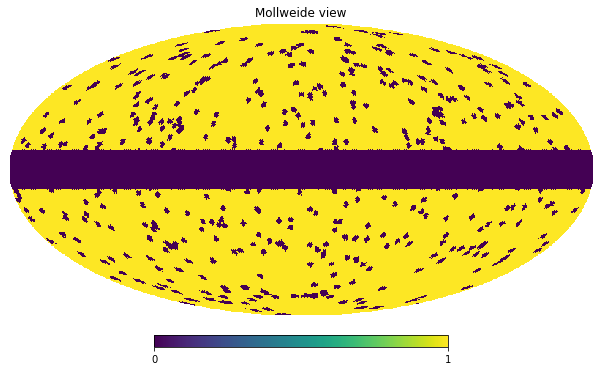

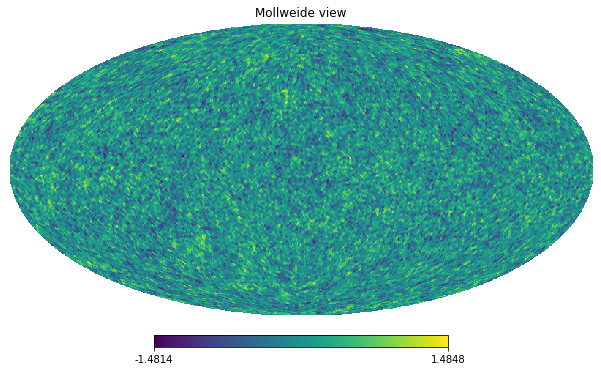

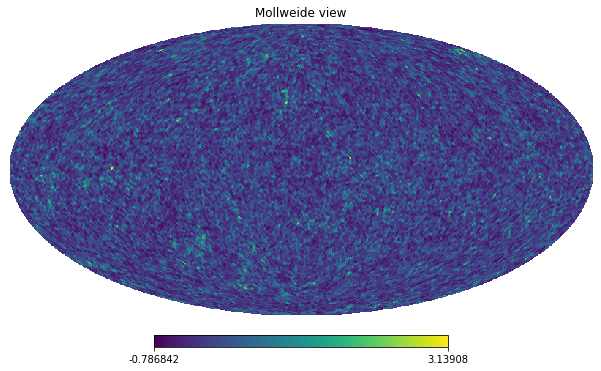

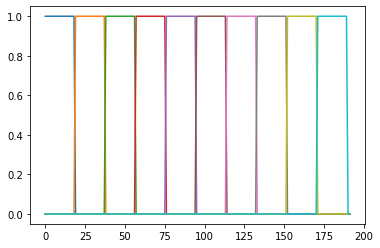

In [3]:
# Pixelization
nside = 64
npix = hp.nside2npix(nside)
_, dec = hp.pix2ang(nside, np.arange(npix), lonlat=True)

# Mask
mask_ones = np.ones(npix)
mask = np.ones(npix)
mask[np.fabs(dec) < 10] = 0
for i in range(500):
    phi = 2*np.pi*np.random.rand()
    cth = -1+2*np.random.rand()
    sth = np.sqrt(1-cth**2)
    v = [sth*np.cos(phi), sth*np.sin(phi), cth]
    mask[hp.query_disc(nside, v, np.radians(1.5))] = 0
hp.mollview(mask)

# Map
ls = np.arange(3*nside)
cl = 5E-3/(ls+10)
fG = hp.synfast(cl, nside)
fLN = np.exp(fG-0.5*np.std(fG)**2)-1
print(np.mean(fG))
print(np.mean(fLN))
hp.mollview(fG)
hp.mollview(fLN)

# Bands
nbands = 10
delL = (3*nside) // nbands
bpws = np.zeros([nbands, 3*nside])
for i in range(nbands):
    bpws[i, i*delL:(i+1)*delL] = 1
plt.figure()
for b in bpws:
    plt.plot(ls, b)

In [4]:
bwp = BispecWorkspace(mask, fLN, bpws, predir='test')
bwp_c = BispecWorkspace(mask_ones, fLN, bpws, predir='full')

In [5]:
bwp.get_mcm()

0
Getting Gs
Getting 2pt
1
Getting Gs
Getting 2pt
2
Getting Gs
Getting 2pt
3
Getting Gs
Getting 2pt
4
Getting Gs
Getting 2pt
5
Getting Gs
Getting 2pt
6
Getting Gs
Getting 2pt
7
Getting Gs
Getting 2pt
8
Getting Gs
Getting 2pt
9
Getting Gs
Getting 2pt
10
Getting Gs
Getting 2pt
11
Getting Gs
Getting 2pt
12
Getting Gs
Getting 2pt
13
Getting Gs
Getting 2pt
14
Getting Gs
Getting 2pt
15
Getting Gs
Getting 2pt
16
Getting Gs
Getting 2pt
17
Getting Gs
Getting 2pt
18
Getting Gs
Getting 2pt
19
Getting Gs
Getting 2pt
20
Getting Gs
Getting 2pt
21
Getting Gs
Getting 2pt
22
Getting Gs
Getting 2pt
23
Getting Gs
Getting 2pt
24
Getting Gs
Getting 2pt
25
Getting Gs
Getting 2pt
26
Getting Gs
Getting 2pt
27
Getting Gs
Getting 2pt
28
Getting Gs
Getting 2pt
29
Getting Gs
Getting 2pt
30
Getting Gs
Getting 2pt
31
Getting Gs
Getting 2pt
32
Getting Gs
Getting 2pt
33
Getting Gs
Getting 2pt
34
Getting Gs
Getting 2pt
35
Getting Gs
Getting 2pt
36
Getting Gs
Getting 2pt
37
Getting Gs
Getting 2pt
38
Getting Gs
Getting 

array([[ 3.59928621e+03,  4.99384539e+01,  3.70349522e+01, ...,
        -3.02985907e+00, -1.19999838e+00, -8.87009644e-02],
       [ 4.99384539e+01,  3.38190078e+03,  3.39684729e+01, ...,
        -1.41390641e+00, -2.45481163e+00,  4.02259021e-01],
       [ 3.70349522e+01,  3.39684729e+01,  5.78306917e+03, ...,
        -1.59168511e+00, -1.51777386e+00,  3.86582448e+00],
       ...,
       [-3.02985907e+00, -1.41390641e+00, -1.59168511e+00, ...,
         7.07344225e+04,  6.43573270e+03,  7.27594747e+02],
       [-1.19999838e+00, -2.45481163e+00, -1.51777386e+00, ...,
         6.43573270e+03,  7.91524868e+04,  1.01581477e+04],
       [-8.87009644e-02,  4.02259021e-01,  3.86582448e+00, ...,
         7.27594747e+02,  1.01581477e+04,  2.65745648e+05]])

In [8]:
bwp_c.get_mcm()

0
Getting Gs
Getting 2pt
1
Getting Gs
Getting 2pt
2
Getting Gs
Getting 2pt
3
Getting Gs
Getting 2pt
4
Getting Gs
Getting 2pt
5
Getting Gs
Getting 2pt
6
Getting Gs
Getting 2pt
7
Getting Gs
Getting 2pt
8
Getting Gs
Getting 2pt
9
Getting Gs
Getting 2pt
10
Getting Gs
Getting 2pt
11
Getting Gs
Getting 2pt
12
Getting Gs
Getting 2pt
13
Getting Gs
Getting 2pt
14
Getting Gs
Getting 2pt
15
Getting Gs
Getting 2pt
16
Getting Gs
Getting 2pt
17
Getting Gs
Getting 2pt
18
Getting Gs
Getting 2pt
19
Getting Gs
Getting 2pt
20
Getting Gs
Getting 2pt
21
Getting Gs
Getting 2pt
22
Getting Gs
Getting 2pt
23
Getting Gs
Getting 2pt
24
Getting Gs
Getting 2pt
25
Getting Gs
Getting 2pt
26
Getting Gs
Getting 2pt
27
Getting Gs
Getting 2pt
28
Getting Gs
Getting 2pt
29
Getting Gs
Getting 2pt
30
Getting Gs
Getting 2pt
31
Getting Gs
Getting 2pt
32
Getting Gs
Getting 2pt
33
Getting Gs
Getting 2pt
34
Getting Gs
Getting 2pt
35
Getting Gs
Getting 2pt
36
Getting Gs
Getting 2pt
37
Getting Gs
Getting 2pt
38
Getting Gs
Getting 

array([[ 5.63803030e+03,  1.00574785e+01,  3.01162802e+01, ...,
         7.12044405e-02,  5.54862801e-02, -1.11217075e-01],
       [ 1.00574785e+01,  5.75864083e+03,  1.71700457e+00, ...,
         3.48383283e-02, -8.64004027e-02, -3.45407300e-01],
       [ 3.01162802e+01,  1.71700457e+00,  9.76920961e+03, ...,
        -2.15254450e-02, -1.23318239e-01,  7.06392340e-03],
       ...,
       [ 7.12044405e-02,  3.48383283e-02, -2.15254450e-02, ...,
         1.20280309e+05,  4.46060039e+03, -2.97695879e+02],
       [ 5.54862801e-02, -8.64004027e-02, -1.23318239e-01, ...,
         4.46060039e+03,  1.37220784e+05,  6.96611114e+03],
       [-1.11217075e-01, -3.45407300e-01,  7.06392340e-03, ...,
        -2.97695879e+02,  6.96611114e+03,  4.67201817e+05]])

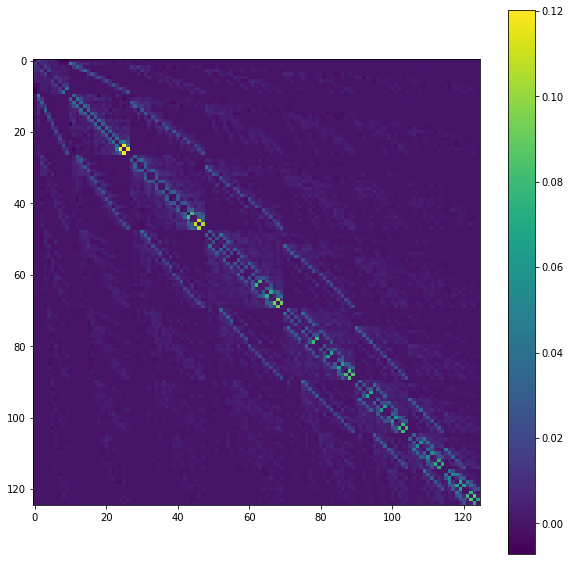

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(bwp.mcm/np.sqrt(np.diag(bwp.mcm)[:, None]*np.diag(bwp.mcm)[None, :])-np.eye(bwp.nbins))
plt.colorbar()

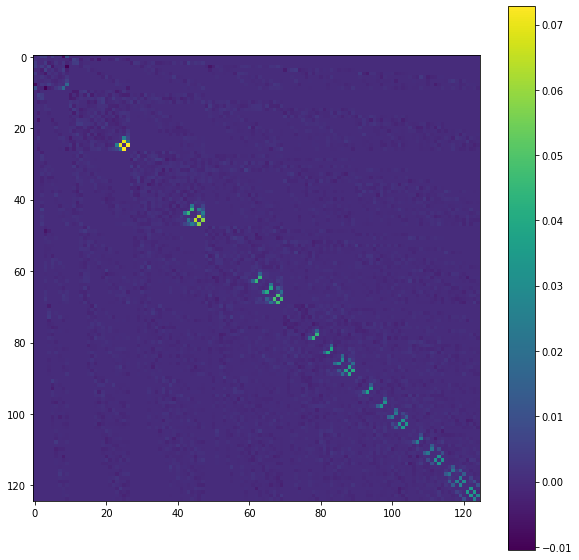

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(bwp_c.mcm/np.sqrt(np.diag(bwp_c.mcm)[:, None]*np.diag(bwp_c.mcm)[None, :])-np.eye(bwp.nbins))
plt.colorbar()

In [13]:
nmod = bwp.get_nmodes()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


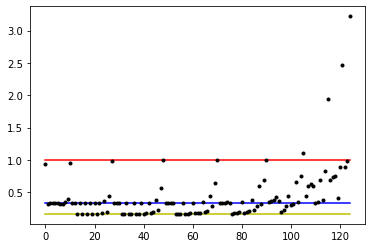

In [18]:
plt.plot(np.arange(bwp_c.nbins), np.ones(bwp_c.nbins), 'r-')
plt.plot(np.arange(bwp_c.nbins), np.ones(bwp_c.nbins)/3, 'b-')
plt.plot(np.arange(bwp_c.nbins), np.ones(bwp_c.nbins)/6, 'y-')
plt.plot(np.diag(bwp_c.mcm)/nmod, 'k.')
